# COVID-19 Vaccination Twitter Clustering

> 👩🏻‍💻 Shengchen Zhang <br>
> ✉️ shengchenzhang1207@gmail.com <br>
> 🏠 College of Design and Innovarion, Tongji University <br>
> 📍 Shanghai, China

Create semantically-meaningful clusters from Twitter discourse on COVID-19 vaccination. The method we use is informed by [BERTopic](https://github.com/MaartenGr/BERTopic) and [this blog post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), modified to fit our purpose.

The steps we take are as follows:
1. Create dense vector embeddings from the original tweet texts.
2. Perform dimensionality reduction on the vectors
3. Cluster the reduced vectors.
4. Filter outliers and merge clusters to arrive at desired number of clusters.

## Step 1: Embed the tweets

Create embedding vectors for the tweets using [SentenceTransformer](https://www.sbert.net/index.html), a transformer-based library that creates dence vector embedding for sentences.

In [38]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

### 1. Create SentenceTransformer model

According to the SentenceTransformer team, `paraphrase-mpnet-base-v2` is the best performing model. But it might be slower to run.

In [39]:
model = SentenceTransformer('paraphrase-mpnet-base-v2')

### 2. Prepare the dataset

Here we load the dataset, then create a list of sentences from that.

In [40]:
import json
from glob import glob

tweet_files = glob('./data/tweets/*.json')
tweets = []

for tweet_file in tweet_files:
    with open(tweet_file) as f:
        tweet = json.loads(f.read())
        tweets.append(tweet)
        
dataset = pd.DataFrame(tweets)
dataset

,uuid,tweet_id,replies,reply_to,avatar,user_handle,user_name,content,date,engagement,avatar_extension
0,8fa3ff53-e055-4502-97b8-11ebf1e6ff46,1339033432056217605,[],None,https://pbs.twimg.com/profile_images/134451886...,fmtoday,Free Malaysia Today,Supplier Fosun Pharma will be making an initia...,"10:23 AM · Dec 16, 2020·Twitter Web App",1 Retweet1 Quote Tweet,jpg
1,fac301a0-cc92-4eeb-857a-dbe64e01d036,1338291694198870017,[],1338287664454393858,https://pbs.twimg.com/profile_images/195683136...,martin_fff,martin_fff,Replying to @AnitaOakville @PattyHajdu and 4 o...,"9:16 AM · Dec 14, 2020·Twitter Web App",2 Likes,jpg
2,50182db7-9e9f-453a-a3fc-a55a404ec1db,1337887453726826497,[],None,https://pbs.twimg.com/profile_images/109603088...,DDNewslive,DD News,#UnitedStates : The Federal Aviation Administr...,"6:30 AM · Dec 13, 2020·TweetDeck",4 Retweets21 Likes,png
3,3ba277f9-a03f-4049-ab15-007f81561c92,1338364933843656704,[],None,https://pbs.twimg.com/profile_images/117134093...,BusinessEstore,Business Technology E-Store | Approved Materials,"Politico. December 13, 2020. FDA's Hahn: Cov...","2:07 PM · Dec 14, 2020·Twitter Web App",1 Retweet,jpg
4,e78360b3-f84e-495c-9b62-7e0f7fc89068,1338560750571446273,[],None,https://pbs.twimg.com/profile_images/123817246...,kfdmnews,KFDM News,KFDM’s/FOX 4’s @THEPAIGEREPORT1 is at Baptist ...,"3:05 AM · Dec 15, 2020·Twitter for iPhone",3 Retweets2 Likes,jpg
...,...,...,...,...,...,...,...,...,...,...,...
327,ff8086a1-418c-4c99-9aa2-08102c5c210e,1338642360561881089,[],1338576273950568451,https://pbs.twimg.com/profile_images/680669217...,Jajngn,Jacque,Replying to @FlyingMagazine\nWell. How about d...,,"8:29 AM · Dec 15, 2020·Twitter for iPhone",jpg
328,e41bcfcd-a404-49d0-968f-12ace90a8b71,1338575542736580619,[],1337863050158804992,https://pbs.twimg.com/profile_images/121770039...,BunnyFeetYeet,pshh...unreal.,Replying to @CurtisSChin\nYes,"4:04 AM · Dec 15, 2020·Twitter for iPhone",1 Like,jpg
329,93974450-1bbe-452f-a59d-35387ceb922f,1337870504699568130,[],1337855739918835717,https://abs.twimg.com/sticky/default_profile_i...,Psudsy1,Psudsy,Replying to @charlesadler and @RexChapman\n@te...,,"5:22 AM · Dec 13, 2020·Twitter Web App",png
330,67e8dee3-ed04-4462-84b6-23148d1cbba9,1337879732663160834,[],None,https://pbs.twimg.com/profile_images/604408122...,world_affairs,World Affairs,New PODCAST: Vaccinating Our Way Out of the Pa...,"5:59 AM · Dec 13, 2020·Twitter Web App",10 Retweets1 Quote Tweet32 Likes,png


In [41]:
sentences = [row['content'] for i, row in dataset.iterrows()]
sentences[:5]

['Supplier Fosun Pharma will be making an initial payment of €125 mil by year-end for 50 million doses. #FMTNews #China #Vaccine #Covid19 #PfizerBioNTech',
 "Replying to @AnitaOakville @PattyHajdu and 4 others\nphoto-op? don't slow the shipment....",
 '#UnitedStates : The Federal Aviation Administration (FAA) said Saturday it had approved the use of the #PfizerBioNTech #COVID19 vaccine by pilots and air traffic controllers. \n@PIB_India @airnewsalerts',
 "Politico.  December 13, 2020.  FDA's Hahn: Covid-19 vaccine authorization based in 'science and data'\nhttps://politico.com/news/2020/12/13/fdas-hahn-coronavirus-vaccine-approval-science-data-444854…\n#coronavirus #covid19 #coronavirusprevention #CoronaVirusUpdate #CoronavirusVaccine #COVID19Vaccine #PfizerBioNTech #business #technology #datascience",
 'KFDM’s/FOX 4’s @THEPAIGEREPORT1 is at Baptist hospital getting a first hand look at where the Pfizer COVID-19 vaccines will be stored.\n\nTune into KFDM and FOX 4 news to find out how 

### 2.5. Testing only: subsample the sentences to speed up the computation

In [42]:
# import random
# sentences = random.sample(sentences, 1000)

### 3. Calculate sentence embeddings (takes a long time!)

In [43]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

## Step 2: Sentiment analysis

In [30]:
from transformers import pipeline
sentiment_analysis = pipeline('sentiment-analysis')

/Users/shauna/.miniforge3/envs/birdseye/lib/python3.9/site-packages/torchaudio/backend/utils.py:67: UserWarning:

No audio backend is available.



Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [37]:
for sentence in sentences:
    print(sentence)
    print(sentiment_analysis(sentence))
    print('\n\n==================================\n\n')

KFDM’s/FOX 4’s @THEPAIGEREPORT1 is at Baptist hospital getting a first hand look at where the Pfizer COVID-19 vaccines will be stored.

Tune into KFDM and FOX 4 news to find out how the hospital is preparing. #COVID19 #Vaccine #PfizerBioNTech
[{'label': 'NEGATIVE', 'score': 0.8949764370918274}]




#SputnikV uses 2 different human adenoviral vectors for 2 vaccine shots to ensure that immunity to the 1st does not make the 2nd less effective. We offered @AstraZeneca to use one of our vectors so they can also have two vectors in their vaccine. AZ confirmed.
[{'label': 'NEGATIVE', 'score': 0.8089855909347534}]




No.1 of 2 done.

#ThankYouNHS @NHSuk @MHRAgovuk and #PfizerBioNTech @pfizer for making the #CovidVaccine dream possible and come to fruition so soon in the UK. #HopeForTheFuture @TeamNUH @NUH_AcuteMed
[{'label': 'POSITIVE', 'score': 0.9973612427711487}]




Singapore approves Pfizer vaccine , becomes first south East Asian country to approve the vaccine. Doses will be given from 

[{'label': 'NEGATIVE', 'score': 0.9945469498634338}]




#PfizerBioNTech's #COVID19 vaccines are making their way to distributions sites nationwide. @FedEx says some of the first batches have been safely delivered.
[{'label': 'POSITIVE', 'score': 0.9705551862716675}]




Last night, the first #COVID19Vaccines arrived in Canada and as we speak, the first of the vaccines are being administered TODAY!

The #PfizerBioNTech vaccine requires storage in extremely low temperatures, and are currently being distributed to 14 locations across Canada.
[{'label': 'NEGATIVE', 'score': 0.9877963662147522}]




Surprised to learn those with autoimmune conditions or otherwise immunosuppressed are advised not to receive the #PfizerBioNTech vaccine per to NACI. These are higher risk folks, and not a live vaccine. I understand questions of efficacy but is there really any safety concern?
[{'label': 'NEGATIVE', 'score': 0.9957643151283264}]




Replying to @yinonw
@DrBenTapper1
[{'label': 'NEGATIVE', 'scor

[{'label': 'NEGATIVE', 'score': 0.9746844172477722}]




Replying to @sputnikvaccine and @AstraZeneca
I wouldn’t trust a medical product from Russia. They poison political opponents.
[{'label': 'NEGATIVE', 'score': 0.9971498250961304}]




Replying to @yinonw and @scientificecon
You are 18X more likely to have permanent heart damage and have 10X more odds of lung damage for every Covid death, among others. So, you may not die but become quite crippled too. I’d rather not take the risk. BTW, the side effects of vaccines seem to be pretty bad too...
[{'label': 'NEGATIVE', 'score': 0.9992288947105408}]




Coronavirus vaccine ships today, expect hospitals to be overwhelmed in nine  months  ...with baby deliveries  #COVID19 #vaccination #PfizerBioNTech #mondaythoughts
[{'label': 'NEGATIVE', 'score': 0.9708686470985413}]




Here are the lipids used in lipid nanoparticle used the #mRNA  BioNTech/Pfizer #PfizerBioNTech  #CovidVaccine The top two are patented by Acutias #Acuitas while 1,2-dis

[{'label': 'NEGATIVE', 'score': 0.9967626333236694}]




In further #Phase3 details from @sporeMOH attractions may start applying to the Singapore Tourism Board (STB) @VisitSingapore to increase operating capacity from 50% to up to 65%
https://moh.gov.sg/news-highlights/details/moving-into-phase-three-of-re-opening…

[{'label': 'POSITIVE', 'score': 0.5557020306587219}]




The end is in sight, many of my coworkers and I are getting our first doses of the #PfizerBioNTech #CovidVaccine today. But as Dr. Milani at @OchsnerHealth emphasizes, stay #vigilant, #MaskUp, do your part and protect your community. #Covid_19 We can end this!
[{'label': 'POSITIVE', 'score': 0.9205706119537354}]




#AnitaQuidangen, a personal support worker in #Toronto, became one of the first people in #Canada to receive a #COVID19  #Vaccine on Dec. 14, 2020. 0:44
1st doses of #PfizerBioNTech COVID-19 vaccine in Canada given in Toronto, #Quebec City
[{'label': 'NEGATIVE', 'score': 0.634627640247345}]




#Singapore

[{'label': 'NEGATIVE', 'score': 0.8089855909347534}]

## Step 3: Dimensionality reduction

We then reduce the dimensionality of the embeddings from 200-D to 5-D. This helps the clustering algorithm.

Here we use UMAP as recommended by [this post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), since it is better at preserving local structures, and tweets are all about subtle local structures.

In [44]:
from umap import UMAP

### 1. Compare UMAP and t-SNE

First, we do a bit of visualization to compare the effectiveness of UMAP and t-SNE. Theoretically, we should observe that UMAP produces **richer structures (clusters, outliers, etc.)**, while t-SNE yields a more **uniform (mixed and spread-out)** result.

In [45]:
import plotly.express as px

reducer = UMAP()

coords = reducer.fit_transform(embeddings).transpose()  # Create a 2-D version for visualization
dataframe = pd.DataFrame({'text': sentences, 'x': coords[0], 'y': coords[1]})

fig = px.scatter(dataframe, x='x', y='y', hover_name='text')
fig.show()

In [46]:
import plotly.express as px
from sklearn.manifold import TSNE

reducer = TSNE(n_components=2)

coords = reducer.fit_transform(embeddings).transpose()  # Create a 2-D version for visualization
dataframe = pd.DataFrame({'text': sentences, 'x': coords[0], 'y': coords[1]})

fig = px.scatter(dataframe, x='x', y='y', hover_name='text')
fig.show()

### 2. The real deal

Now is time to really do the reduction. We create a UMAP reducer with `n_components=5` to get 5-D vectors.

In [70]:
reducer = UMAP(n_components=5, n_neighbors=5)
reduced = reducer.fit_transform(embeddings)
reduced.shape  # Should be (*, 5)

(332, 5)

## Step 3: Clustering

Using the reduced vectors, we can now cluster our tweets.

Also following [this post](https://www.atoti.io/topic-modeling-on-twitter-using-sentence-bert/), we use HDBSCAN to cluster out tweets. According to the author, this algorithm is better at filtering out outliers.

In [71]:
from hdbscan import HDBSCAN
from scipy.cluster.hierarchy import fcluster

clusterer = HDBSCAN(min_cluster_size=10)
clusterer.fit(reduced)
# labels = clusterer.fit_predict(reduced)

Z = clusterer.single_linkage_tree_.to_numpy()
labels = fcluster(Z, 4, criterion='maxclust')

<AxesSubplot:ylabel='$\\lambda$ value'>

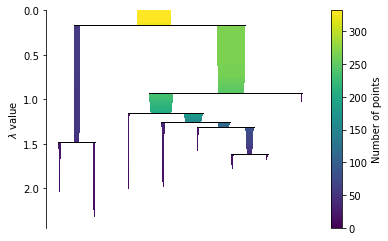

In [72]:
clusterer.condensed_tree_.plot()

## Step 4: Visualization of results

In [73]:
import plotly.express as px

reducer = UMAP()

coords = reducer.fit_transform(embeddings).transpose()  # Create a 2-D version for visualization
dataframe = pd.DataFrame({'text': sentences, 'x': coords[0], 'y': coords[1], 'cluster': labels})

fig = px.scatter(dataframe, x='x', y='y', hover_name='text', color='cluster')
fig.show()

In [24]:
dataset = dataframe[dataframe['cluster'] != -1]